In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import math
import string
import collections
import matplotlib.pyplot as plt
import pathlib
from collections import defaultdict
import pickle 

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

# Data

In [ ]:
image_dir = './data/1864_33884_upload_images/'
classes = os.listdir(image_dir)
classes_dict = {
    classes[x]: x
    for x in range(len(classes))
}

data_dir = pathlib.Path(image_dir)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [ ]:
image_count = 0
for c in classes:
    for _ in range(len(os.listdir(image_dir + c))):
        image_count += 1

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    
    # The second to last is the class-directory
    t = parts[-2] == classes
    t = tf.cast(t, dtype=tf.int32)
    return t

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [INPUT_SHAPE[0], INPUT_SHAPE[1]])

def process_path(file_path):
    label = get_label(file_path)

    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare_for_training(ds, batch_size, train=None, cache=False, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    
    if train:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.batch(batch_size)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTO)
    
    ds = ds.repeat()

    return ds


In [ ]:
INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 32
STEPS_PER_EPOCH = image_count // BATCH_SIZE

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTO)
train_ds = prepare_for_training(labeled_ds, BATCH_SIZE, train=True)

In [ ]:
def augmentation(image, labels):
    image = tf.image.resize(image, size=(128, 128))
    return image, labels

# Models

### YoloV1-Tiny

In [ ]:
def build_yolov1_tiny(initalization, batchnorm):
    if batchnorm:
        model = yolov1_tiny_bn = tf.keras.Sequential([
            Conv2D(input_shape=INPUT_SHAPE, filters=16, kernel_size=(3, 3), 
                   strides=(1, 1), padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            Flatten(),
            Dense(1470, kernel_initializer=initalization),
            Dense(101, kernel_initializer=initalization, activation='softmax')
        ])
        
        return model
    
    else:
        model = yolov1_tiny_bn = tf.keras.Sequential([
            Conv2D(input_shape=INPUT_SHAPE, filters=16, kernel_size=(3, 3), 
                   strides=(1, 1), padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            Flatten(),
            Dense(1470, kernel_initializer=initalization),
            Dense(101, kernel_initializer=initalization, activation='softmax')
        ])
        
        return model
        

#### Training loop: please alter lines 8 (initializer) and 10 (batchnorm)

In [ ]:
yolov1_tiny_bn_results = defaultdict()

for n in range(3):
    seed = np.random.randint(1111)
    yolov1_tiny_bn_results[n] = defaultdict()
    yolov1_tiny_bn_results[n]['seed'] = seed
    
    he_norm = tf.keras.initializers.he_normal(seed)
    
    yolov1_tiny_bn = build_yolov1_tiny(initalization=he_norm, batchnorm=False)
    
    yolov1_tiny_bn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    history = yolov1_tiny_bn.fit(
        train_ds,
        epochs=50,
        steps_per_epoch=STEPS_PER_EPOCH
    )
    
    yolov1_tiny_bn_results[n]['loss'] = history.history['loss']
    yolov1_tiny_bn_results[n]['acc'] = history.history['categorical_accuracy']

In [ ]:
with open('./results/tiny_yolo_no_saxe', 'wb') as handle:
    pickle.dump(yolov1_tiny_bn_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
del yolov1_tiny_bn

# ResNet26

In [ ]:
class BasicBlockBN(tf.keras.layers.Layer):

    def __init__(self, filter_num, initializer, stride=1):
        super(BasicBlockBN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same",
                                            kernel_initializer=initializer,
                                            activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same",
                                            kernel_initializer=initializer,
                                            activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride,
                                                       kernel_initializer=initializer,
                                                       activation='relu'))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output
    
class BasicBlockNO(tf.keras.layers.Layer):

    def __init__(self, filter_num, initializer, stride=1):
        super(BasicBlockNO, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same",
                                            kernel_initializer=initializer,
                                            activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same",
                                            kernel_initializer=initializer,
                                            activation='relu')
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride,
                                                       kernel_initializer=initializer,
                                                       activation='relu'))
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.conv2(x)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

def make_basic_block_layer(filter_num, blocks, initializer, batchnorm, stride=1):
    res_block = tf.keras.Sequential()
    
    if batchnorm:
        res_block.add(BasicBlockBN(filter_num, stride=stride, initializer=initializer))

        for _ in range(1, blocks):
            res_block.add(BasicBlockBN(filter_num, stride=1, initializer=initializer))

        return res_block
    
    else:
        res_block.add(BasicBlockNO(filter_num, stride=stride, initializer=initializer))
        
        for _ in range(1, blocks):
            res_block.add(BasicBlockNO(filter_num, stride=1, initializer=initializer))
            
        return res_block

In [ ]:
def build_resnet26(initializer, batchnorm):
    model = tf.keras.Sequential([
        Conv2D(input_shape=INPUT_SHAPE, filters=64, kernel_size=(7, 7), 
               strides=2, padding='same', kernel_initializer=initializer, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

        # Each one of these is 2 BasicBlock
        make_basic_block_layer(filter_num=64, blocks=2, stride=2, 
                               initializer=initializer, batchnorm=batchnorm),
        make_basic_block_layer(filter_num=128, blocks=2, stride=2, 
                               initializer=initializer, batchnorm=batchnorm),
        make_basic_block_layer(filter_num=256, blocks=2, stride=2, 
                               initializer=initializer, batchnorm=batchnorm),
        make_basic_block_layer(filter_num=512, blocks=2, stride=2, 
                               initializer=initializer, batchnorm=batchnorm),
        GlobalAveragePooling2D(),
        Dense(101, kernel_initializer=initializer, activation='softmax')

    ])

    return model

#### Training loop: please alter lines 8 (initializer) and 10 (batchnorm)

In [ ]:
resnet_bn_results = defaultdict()

for n in range(3):
    seed = np.random.randint(1111)
    resnet_bn_results[n] = defaultdict()
    resnet_bn_results[n]['seed'] = seed
    
    he_norm = tf.keras.initializers.he_normal(seed)
    
    resnet = build_resnet26(initializer=he_norm, batchnorm=True)
    
    resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    history = resnet.fit(
        train_ds,
        epochs=50,
        steps_per_epoch=STEPS_PER_EPOCH
    )
    
    resnet_bn_results[n]['loss'] = history.history['loss']
    resnet_bn_results[n]['acc'] = history.history['categorical_accuracy']

In [ ]:
with open('./results/resnet_bn_he', 'wb') as handle:
    pickle.dump(resnet_bn_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
resnet_bn_results = defaultdict()

for n in range(3):
    seed = np.random.randint(1111)
    resnet_bn_results[n] = defaultdict()
    resnet_bn_results[n]['seed'] = seed
    
    he_norm = tf.keras.initializers.he_normal(seed)
    
    resnet = build_resnet26(initializer=he_norm, batchnorm=False)
    
    resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    history = resnet.fit(
        train_ds,
        epochs=50,
        steps_per_epoch=STEPS_PER_EPOCH
    )
    
    resnet_bn_results[n]['loss'] = history.history['loss']
    resnet_bn_results[n]['acc'] = history.history['categorical_accuracy']

In [ ]:
with open('./results/resnet_no_he', 'wb') as handle:
    pickle.dump(resnet_bn_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Compiling the results

In [2]:
result_files = [
    './results/tiny_yolo_bn_glorot',
    './results/tiny_yolo_no_glorot',
    './results/tiny_yolo_bn_he',
    './results/tiny_yolo_no_he',
    './results/resnet_bn_glorot',
    './results/resnet_no_glorot',
    './results/resnet_bn_he',
    './results/resnet_no_he'
]

compiled_results = defaultdict()

for file in result_files:
#     compiled_results[file] = defaultdict()
    with (open(file, "rb")) as openfile:
        compiled_results[file] = pickle.load(openfile)

In [ ]:
compiled_results.keys()

In [ ]:
compiled_results[result_files[0]][0]

#### Tiny-Yolo BN

In [3]:
ty_bn = ['./results/tiny_yolo_bn_glorot','./results/tiny_yolo_bn_he']

ty_bn_g = compiled_results[ty_bn[0]]

ty_bn_g_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_g_acc.append(ty_bn_g[iteration]['acc'])    

ty_bn_h = compiled_results[ty_bn[1]]

ty_bn_h_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_h_acc.append(ty_bn_h[iteration]['acc'][:50]) # started out at 100 iters per

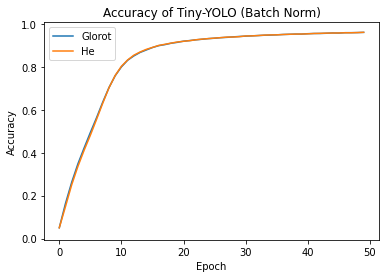

In [4]:
plt.plot(np.mean(ty_bn_g_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_g_acc, axis=0), 
                 np.max(ty_bn_g_acc, axis=0), alpha=0.2)

plt.plot(np.mean(ty_bn_h_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_h_acc, axis=0), 
                 np.max(ty_bn_h_acc, axis=0), alpha=0.2)

plt.title('Accuracy of Tiny-YOLO (Batch Norm)')
plt.legend(['Glorot', 'He'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('./results/ty_bn.png', dpi=400)

#### Tiny-Tolo NO

In [5]:
ty_bn = ['./results/tiny_yolo_no_glorot','./results/tiny_yolo_no_he']

ty_bn_g = compiled_results[ty_bn[0]]

ty_bn_g_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_g_acc.append(ty_bn_g[iteration]['acc'])    

ty_bn_h = compiled_results[ty_bn[1]]

ty_bn_h_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_h_acc.append(ty_bn_h[iteration]['acc'][:50]) # started out at 100 iters per

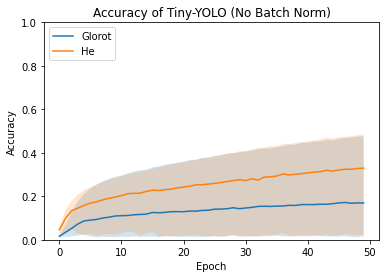

In [6]:
plt.plot(np.mean(ty_bn_g_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_g_acc, axis=0), 
                 np.max(ty_bn_g_acc, axis=0), alpha=0.2)

plt.plot(np.mean(ty_bn_h_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_h_acc, axis=0), 
                 np.max(ty_bn_h_acc, axis=0), alpha=0.2)

plt.title('Accuracy of Tiny-YOLO (No Batch Norm)')
plt.legend(['Glorot', 'He'], loc=2)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.savefig('./results/ty_no.png', dpi=400)

#### ResNet BN

In [7]:
ty_bn = ['./results/resnet_bn_glorot','./results/resnet_bn_he']

ty_bn_g = compiled_results[ty_bn[0]]

ty_bn_g_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_g_acc.append(ty_bn_g[iteration]['acc'])    

ty_bn_h = compiled_results[ty_bn[1]]

ty_bn_h_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_h_acc.append(ty_bn_h[iteration]['acc'][:50]) # started out at 100 iters per

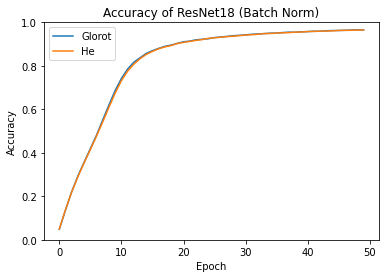

In [8]:
plt.plot(np.mean(ty_bn_g_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_g_acc, axis=0), 
                 np.max(ty_bn_g_acc, axis=0), alpha=0.2)

plt.plot(np.mean(ty_bn_h_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_h_acc, axis=0), 
                 np.max(ty_bn_h_acc, axis=0), alpha=0.2)

plt.title('Accuracy of ResNet18 (Batch Norm)')
plt.legend(['Glorot', 'He'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.savefig('./results/res_bn.png', dpi=400)

#### ResNet NO

In [9]:
ty_bn = ['./results/resnet_no_glorot','./results/resnet_no_he']

ty_bn_g = compiled_results[ty_bn[0]]

ty_bn_g_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_g_acc.append(ty_bn_g[iteration]['acc'])    

ty_bn_h = compiled_results[ty_bn[1]]

ty_bn_h_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_h_acc.append(ty_bn_h[iteration]['acc'][:50]) # started out at 100 iters per

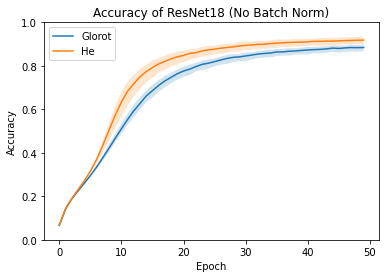

In [10]:
plt.plot(np.mean(ty_bn_g_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_g_acc, axis=0), 
                 np.max(ty_bn_g_acc, axis=0), alpha=0.2)

plt.plot(np.mean(ty_bn_h_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_h_acc, axis=0), 
                 np.max(ty_bn_h_acc, axis=0), alpha=0.2)

plt.title('Accuracy of ResNet18 (No Batch Norm)')
plt.legend(['Glorot', 'He'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.savefig('./results/res_no.png', dpi=400)